# Linear Regression: Training, Testing, and Predicting

# 1. General Setup

In [1]:
# Import analytics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import machine learning dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Raise errors, instead of give warnings
pd.set_option('mode.chained_Assignment', 'raise')

In [3]:
# Import data
import os
data_file_path = os.path.join('Data','stocks.csv')

# Preview data
stocks = pd.read_csv(data_file_path, index_col='Date')
display(stocks.head())
display(stocks.tail())

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,69.078238
2004-08-20,54.322689,7.227007,8.537313,22834300.0,67.839414
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,68.912727
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,70.668146
2004-08-25,53.164113,1.183658,3.966115,9188600.0,71.219849


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2018-03-21,1094.00,0.130884,1.976619,1990515.0,NaN
2018-03-22,1053.15,-2.487014,3.265882,3418154.0,NaN
2018-03-23,1026.55,-2.360729,4.089299,2413517.0,NaN
2018-03-26,1054.09,0.332191,4.818025,3272409.0,NaN
2018-03-27,1006.94,-5.353887,6.707965,2940957.0,NaN


# 2. Preprocessing

In [4]:
# define features and labels
X = np.array(stocks.drop(['Forecast'], 1))
y = np.array(stocks['Forecast'])

print(X)
print(y)

[[ 5.03228418e+01  3.24967503e-01  8.44101709e+00  4.46590000e+07]
 [ 5.43226889e+01  7.22700723e+00  8.53731343e+00  2.28343000e+07]
 [ 5.48693765e+01 -1.22788010e+00  4.06235672e+00  1.82561000e+07]
 ...
 [ 1.02655000e+03 -2.36072933e+00  4.08929913e+00  2.41351700e+06]
 [ 1.05409000e+03  3.32191129e-01  4.81802529e+00  3.27240900e+06]
 [ 1.00694000e+03 -5.35388664e+00  6.70796496e+00  2.94095700e+06]]
[69.0782379  67.83941377 68.91272699 ...         nan         nan
         nan]


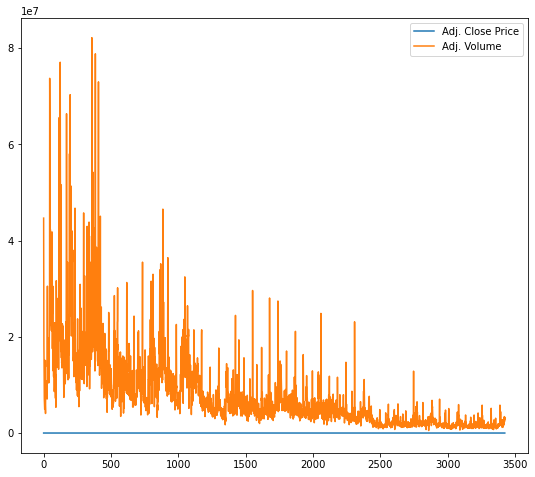

In [5]:
# Preview pre-scaled data
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(X[:,0], label='Adj. Close Price')
plt.plot(X[:,3], label = 'Adj. Volume')
plt.legend()

In [6]:
# Create copies of original data
X_original = X.copy(order='C')
y_original = y.copy(order='C')

# Initialize scaler
scaler = StandardScaler()

# Fit data
scaler.fit(X, y)

# Scale features
X = scaler.transform(X)

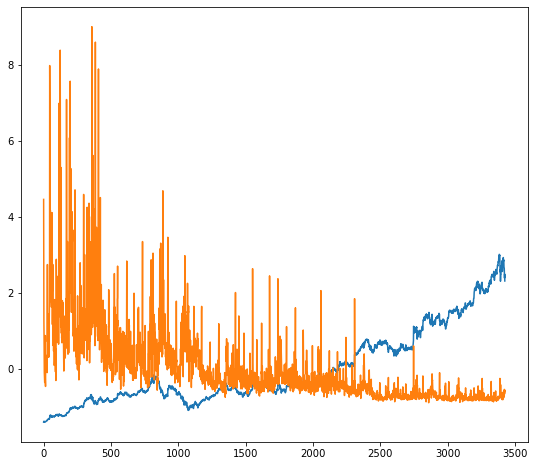

In [7]:
# Preview scaled data
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(X[:,0], label='Adj. Close Price')
plt.plot(X[:,3], label='Adj. volume')

# 3. Address Missing Values

Recall that make our forecast column, we shifted each adjusted close price up $x$ rows, where $x$ was 1% of the length of the dataframe, which in this case was 35 rows.  Consequently, the last 35 rows of the forecast column are null, as there were no values to shift into these rows.

In [8]:
# Define the number of days out we want to forecast out
# In this case, want to forecast out 1% of the dataframe
# We will use the math ceil() function to round the number of columns to the nearest whole number.
import math
forecast_out = math.ceil(0.01*len(stocks))
print(forecast_out)

35


We will now examine the last 37 rows of our dataframe to observe this phenomenon.  The last 35 rows will be null, while the first 2 will have values.

In [9]:
# View last 37 rows of data
display(stocks.tail(forecast_out+2))

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2018-02-02,1119.20,-0.729098,1.811604,5798880.0,1054.09
2018-02-05,1068.76,-2.893850,5.512236,3742469.0,1006.94
2018-02-06,1084.43,4.879205,5.569849,3732527.0,NaN
2018-02-07,1055.41,-2.724499,3.025734,2544683.0,NaN
2018-02-08,1005.60,-5.120439,5.851043,3067173.0,NaN
2018-02-09,1043.43,1.710726,5.488465,4436032.0,NaN
2018-02-12,1054.56,-0.199684,1.920631,2796258.0,NaN
2018-02-13,1054.14,0.394286,1.365911,1574121.0,NaN
2018-02-14,1072.70,1.743304,2.445228,2029979.0,NaN


The Linear Regression algorithm we will soon use cannot take null values, and will error out if we pass in this data in its current state.  Though it is generally recommended to fill in missing data, we will simply drop ours to not overcomplicate learning our first algorithm.

Observe what happens if we select up until the last 35 records of our labels, vs what happens if we select up to the last 37 records.

In [10]:
# View last 35 rows of data, and last 37 rows
# to illustrate up to what point we have data
display(y[:-forecast_out])
display(y[:-forecast_out+2])

array([  69.0782379 ,   67.83941377,   68.91272699, ..., 1026.55      ,
       1054.09      , 1006.94      ])

array([  69.0782379 ,   67.83941377,   68.91272699, ..., 1006.94      ,
                 nan,           nan])

Now we will select only the last record from our labels, only our 35$^{th}$ to last record, only our 36$^{th}$ to last record, and only our 37$^{th}$ to last record.

In [11]:
# View last row of data, and rows 35, 36, and 37 from the last
# to illustrate up to what point we have data
display(y[-1])
display(y[-35])
display(y[-36])
display(y[-37])

nan

nan

1006.94

1054.09

The last record, up to the 35$^{th}$ to last are null.  From the beginning of the array up until the 36$^{th}$ we do have values.  We will therefore overwrite our features and labels by selecting up to the point where we still have data.

In [12]:
# Define features and labels to be only up to the point without missing data
X = X[:-forecast_out]
y = y[:-forecast_out]

We will then select the last two values in our labels to confirm their value.

In [13]:
# Preview last 2 rows of data, to confirm no data is missing
display(y[-1])
display(y[-2])

1006.94

1054.09

We see the same values that we saw 36 and 37 rows from the last, and have removed any missing data.  We are now ready to train a machine learning classifier.

# 4. Training Machine Learning Classifier

In general, the next steps at this point are splitting the data into training and testing sets, using the defined machine learning algorithm on the training set, then testing the accuracy on the test set.

Under the hood, Linear Regression determines a best-fit line to model the relationship between the features and the labels, or in other words, it determines the coefficients to model a best-fit line for the data.  Afterwards, we pass testing features into this best-fit line, and measure how accurate they are compared to the actual labels.

In [14]:
# Split training and testing data, with 20% of the data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Define the type of classifier; we are using Linear Regression
classifier = LinearRegression()

# Train the classifier;
# this determines the coefficients to model the best-fit line
classifier.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Check the accuracy when using this classifier on testing data
classifier.score(X_test, y_test)

0.9802809260327793

By checking the score above, we can see that this model had 98% accuracy when predicting the labels on the testing set.  If we are happy with this accuracy, we can proceed to deploy this model for real-world use.

# 5. Using Our Model To Predict Future Values

# Sources: 
1. <a href="https://pythonprogramming.net/training-testing-machine-learning-tutorial/" target="_blank">Python Programming: Regression - Training and Testing</a>
2. <a href="https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/" target="_blank">Python Programming: Regression - Forecasting and Predicting</a>